In [1]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import sigmoid, get_abs_evidence

import seaborn as sns


# sklearn packages 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import metrics

'''this script concate each block per subject to a file wihthin subject called s103_df_concat.csv'''

'''subsequently save a concatenante file under rechain-beh called all_df_concat.csv '''


# global setting f
plt.rcParams.update({"font.size": 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")


In [2]:


PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')



In [3]:
list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

df = df[df['count'] >=3]
df = df[df['stimDur'] != 0.5]
df = df[df['stimDur'] != 0.05]
cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count'].to_numpy()

/tmp/ipykernel_1589352/511193723.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_1589352/511193723.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_1589352/511193723.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [4]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ..."
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ..."
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ..."
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ..."
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0..."


In [92]:
def get_chain_matrix(sequence, count):
    chain_matrix = np.zeros_like(sequence)
    chain_matrix.fill(np.nan)
    for c in range(sequence.shape[0]):
        chain_matrix[c, : int(count[c])] = sequence[c, : int(count[c])]
    return chain_matrix

In [105]:
def make_dataset(num_of_samples, count, chain_matrix):

    dataset = chain_matrix[count>=num_of_samples, :]
    dataset_resp = np.isnan(dataset[:, num_of_samples])  # True means they stopped, false means they kept going
    dataset = dataset[:, :num_of_samples]

    return dataset, dataset_resp

In [106]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [107]:

# # calculate terminated chains
# cumsum_stop_list = []

# for c in range(cumsum.shape[0]):
#     cumsum_stop = cumsum[
#         c, : int(count[c])
#     ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
#     cumsum_stop_list.append(cumsum_stop)
 



In [132]:
    dataset, dataset_resp = make_dataset(6, count, chain_matrix)


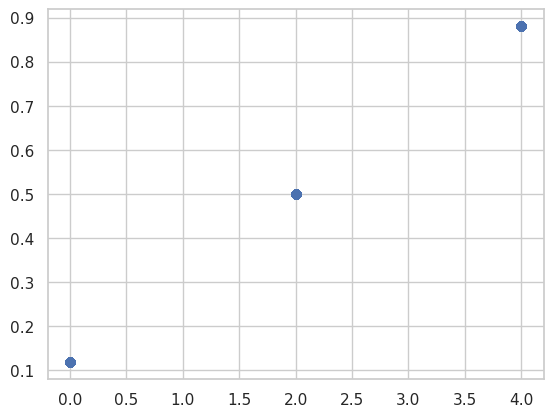

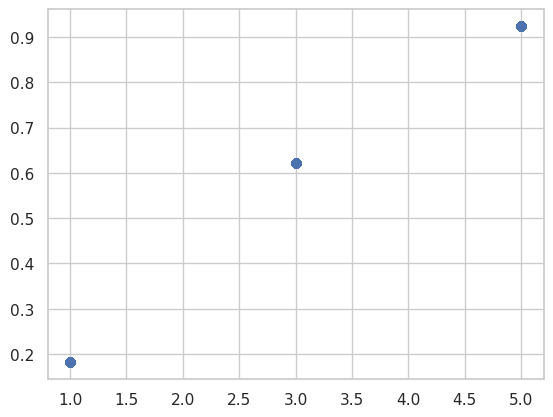

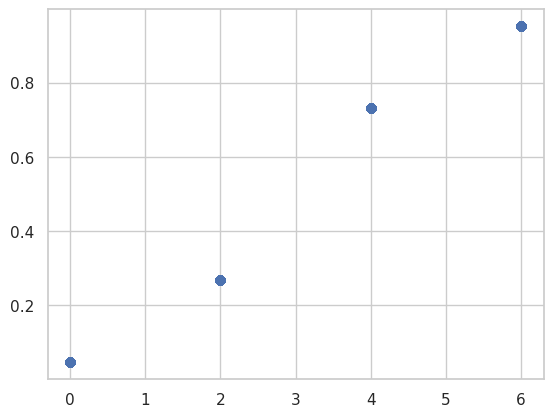

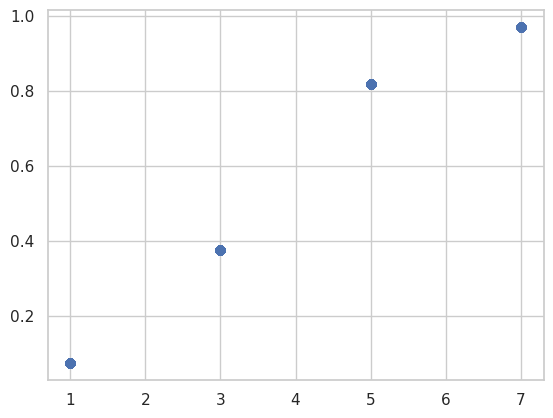

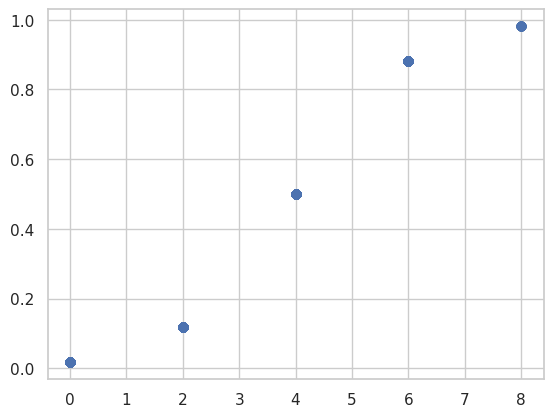

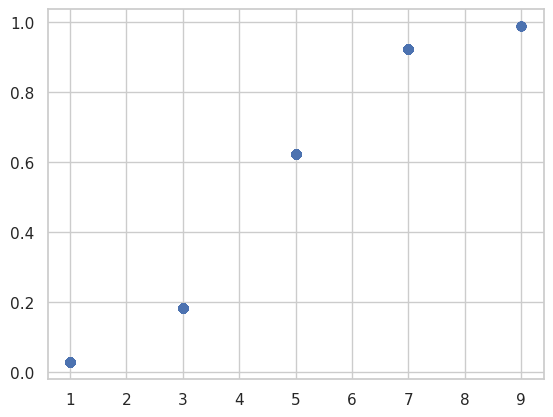

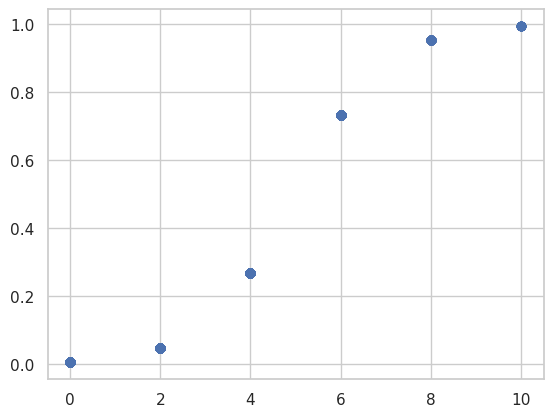

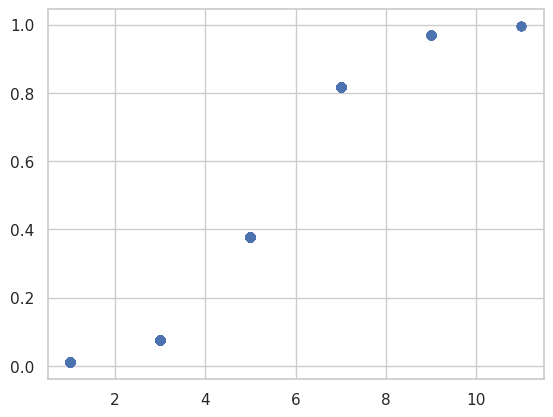

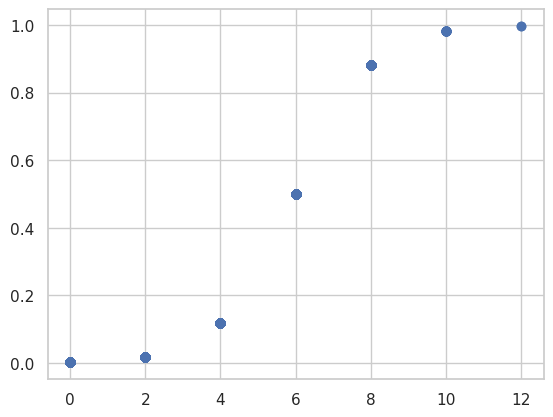

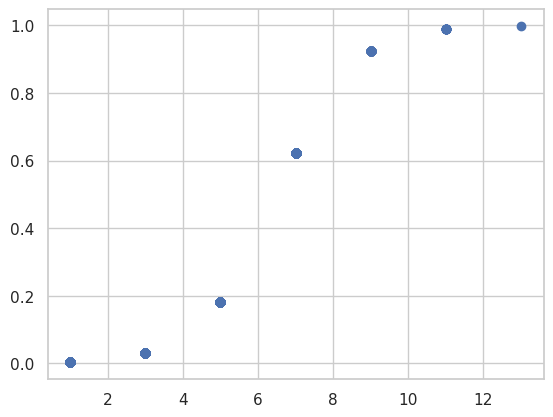

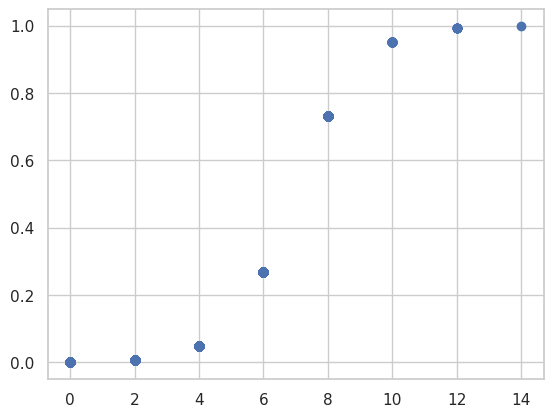

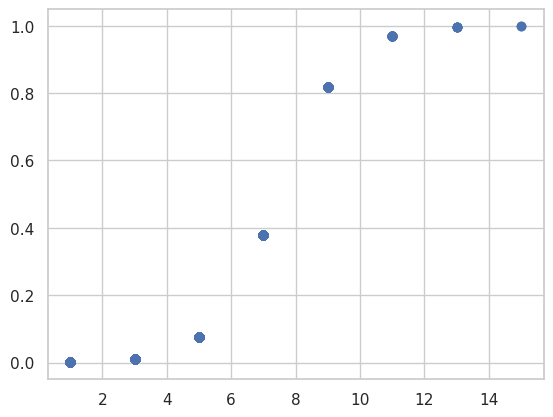

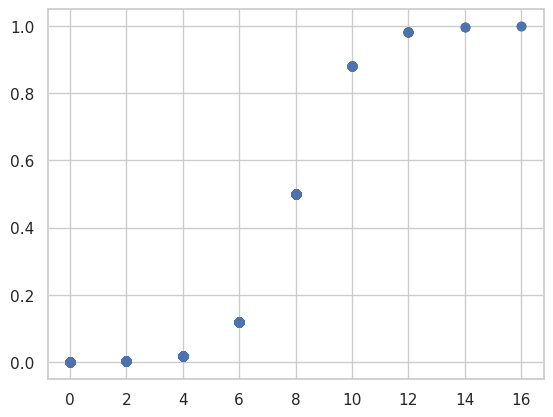

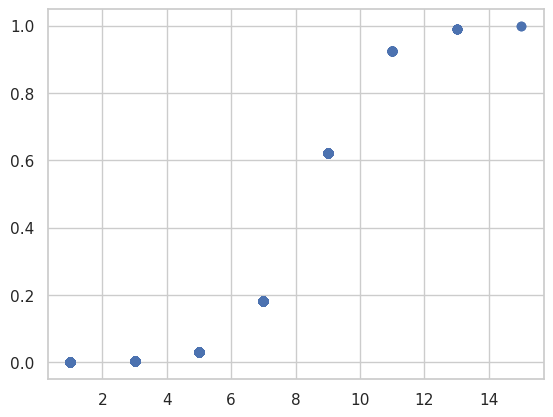

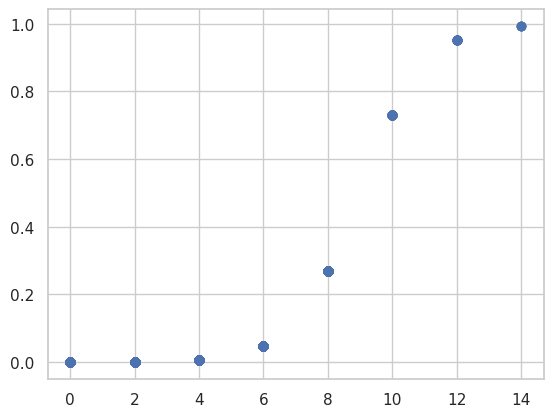

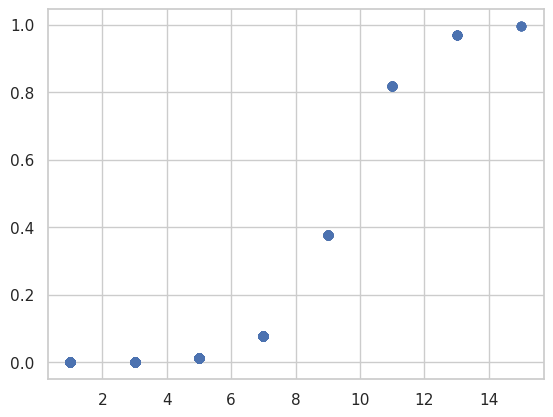

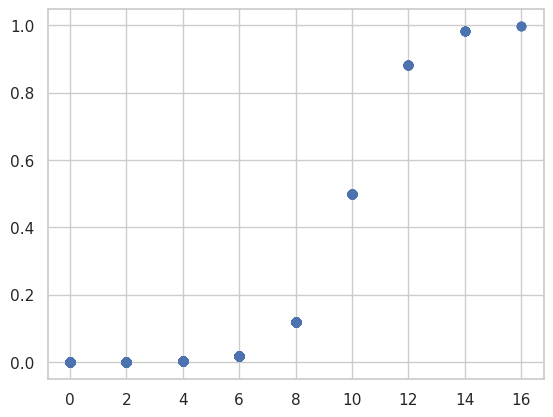

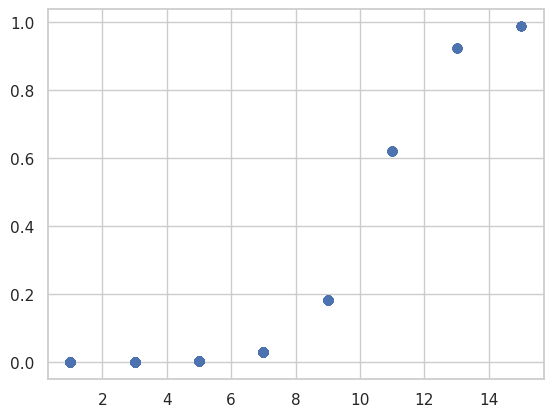

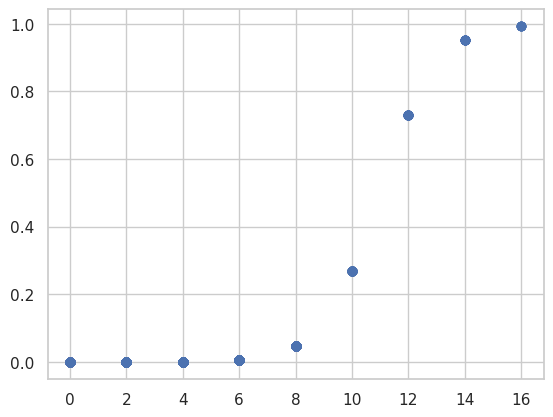

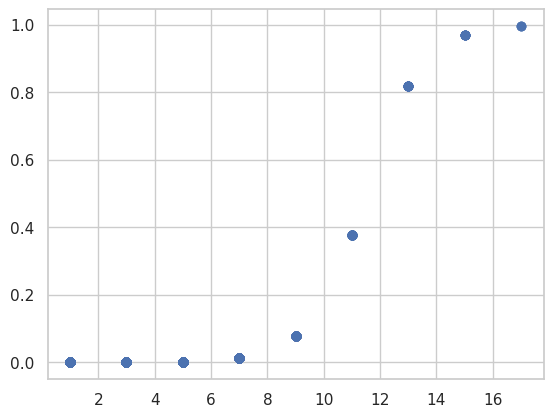

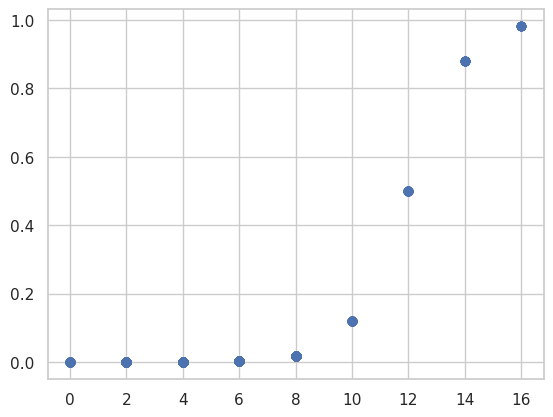

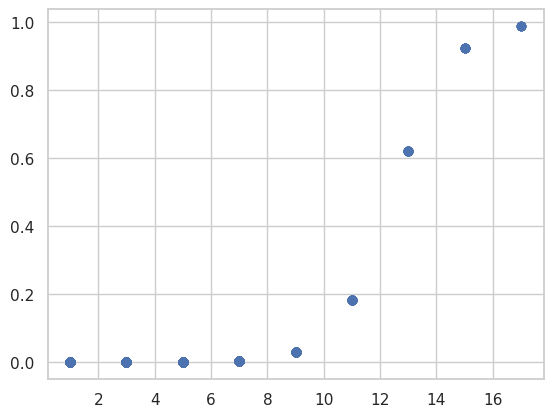

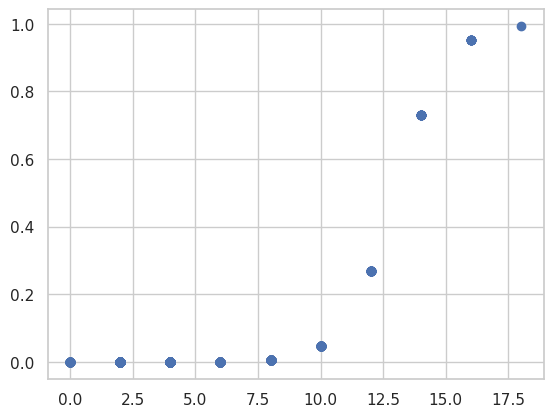

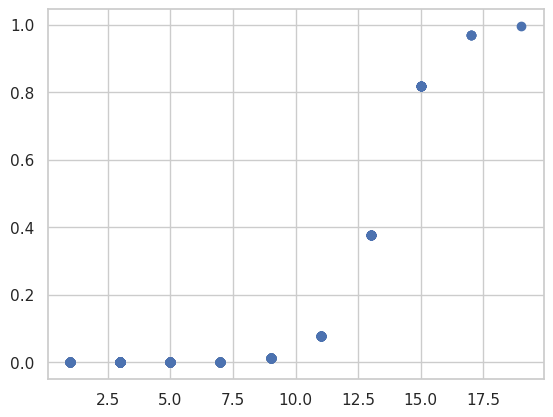

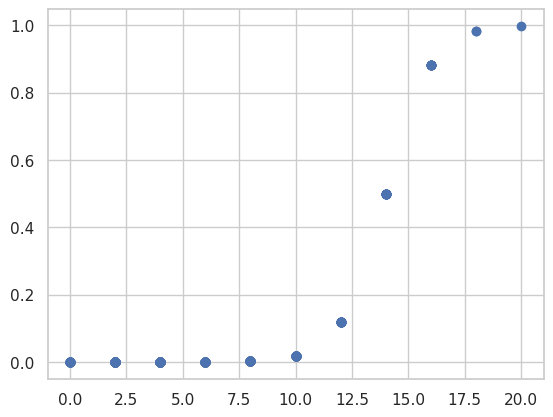

In [210]:
# set which sample
TRUE_N = []
TOTAL_N = []
FPR_TRAIN =[]
FPR_TEST =[]
TPR_TRAIN=[]
TPR_TEST=[]
AUC_TRAIN =[]
AUC_TEST =[]
POSITION_OF_SAMPLES=[]
N_TRAIN =[]
N_TEST = []

sigmoid_param =[1, 0]
for number_of_samples in np.arange(4,29):
    dataset, dataset_resp = make_dataset(number_of_samples, count, chain_matrix)
    TRUE_N.append(dataset_resp.sum())
    TOTAL_N.append(len(dataset))
    x_train, x_test, y_train, y_test = train_test_split(
        dataset, dataset_resp, test_size=0.3, random_state=2024
    )
    N_TRAIN.append(len(x_train))
    N_TEST.append(len(x_test))
    # integrate evidence    
    x_train_evidence = get_abs_evidence(x_train)[:,-1]
    x_test_evidence = get_abs_evidence(x_test)[:,-1]

    # predict prob
    y_pred_prob_train = sigmoid(x_train_evidence,alpha=sigmoid_param[0],beta=number_of_samples/2)
    y_pred_prob_test = sigmoid(x_test_evidence,alpha=sigmoid_param[0],beta=number_of_samples/2)

    # plot ROC

    fpr_train, tpr_train, thresh = metrics.roc_curve(y_train, y_pred_prob_train)
    fpr_test, tpr_test, thresh = metrics.roc_curve(y_test, y_pred_prob_test)
    auc_train = metrics.auc(fpr_train, tpr_train)
    auc_test = metrics.auc(fpr_test, tpr_test)
    FPR_TRAIN.append(fpr_train)
    FPR_TEST.append(fpr_test)
    TPR_TRAIN.append(tpr_train)
    TPR_TEST.append(tpr_test)
    AUC_TRAIN.append(auc_train)
    AUC_TEST.append(auc_test)
    POSITION_OF_SAMPLES.append(number_of_samples)
    plt.scatter(x_train_evidence,y_pred_prob_train)
    plt.show()


In [211]:
def plot_roc(fpr_list, tpr_list, auc_list, position_of_samples, total_n_list, auc_cutoff=0.5):
    fig, ax = plt.subplots(1,1)
    for i in range(len(fpr_list)):
        if auc_list[i]>=auc_cutoff:
            if i == np.argmax(auc_list):
                ax.plot(fpr_list[i],tpr_list[i],label=f'number of samples: {str(position_of_samples[i])}, auc={np.round(auc_list[i],2)}, n = {total_n_list[i]}', linewidth = 4)
            else:
                ax.plot(fpr_list[i],tpr_list[i],label=f'number of samples: {str(position_of_samples[i])}, auc={np.round(auc_list[i],2)}, n = {total_n_list[i]}')
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--", alpha=0.5)
    ax.legend(bbox_to_anchor=(1,1,0,0))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    return fig,ax

Text(0.5, 1.0, 'Training Data AUC')

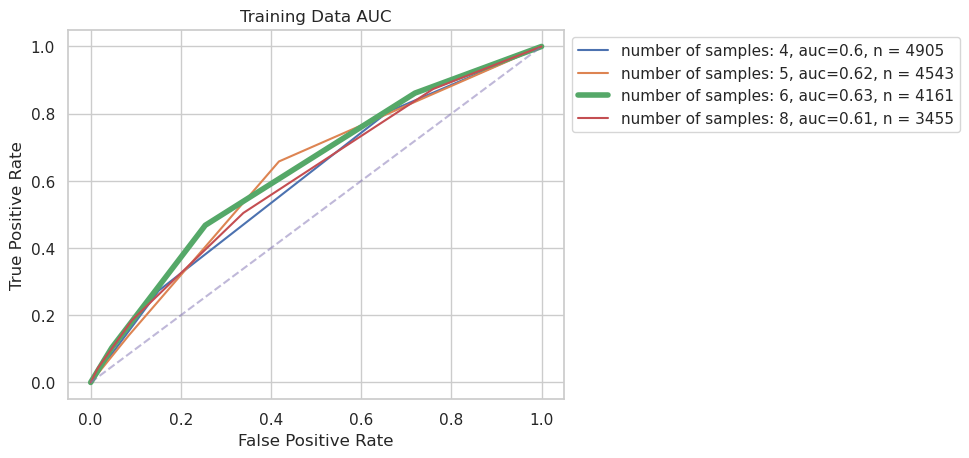

In [230]:
fig,ax = plot_roc(FPR_TRAIN,TPR_TRAIN,AUC_TRAIN, POSITION_OF_SAMPLES, N_TRAIN, auc_cutoff = 0.6)
ax.set_title("Training Data AUC")

Text(0.5, 1.0, 'Test Data AUC')

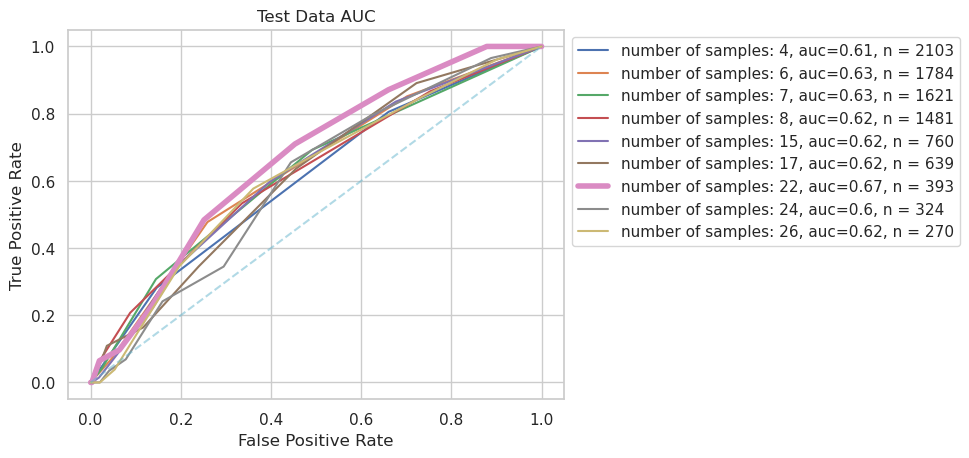

In [231]:
fig,ax = plot_roc(FPR_TEST,TPR_TEST,AUC_TEST, POSITION_OF_SAMPLES, N_TEST, auc_cutoff = 0.6)
ax.set_title("Test Data AUC")

In [223]:
def plot_roc_per_sample_position(auc_list_train, auc_list_test, position_of_samples):
    fig, ax = plt.subplots(1,1)
    ax.plot(position_of_samples, auc_list_train,'-o', label = 'training data')
    ax.plot(position_of_samples, auc_list_test,'-o', label = 'test data')

    ax.set_xlabel("Position of sample")
    ax.set_ylabel("AUC")
    ax.set_ylim(0,1)
    fig.legend()
    return fig, ax


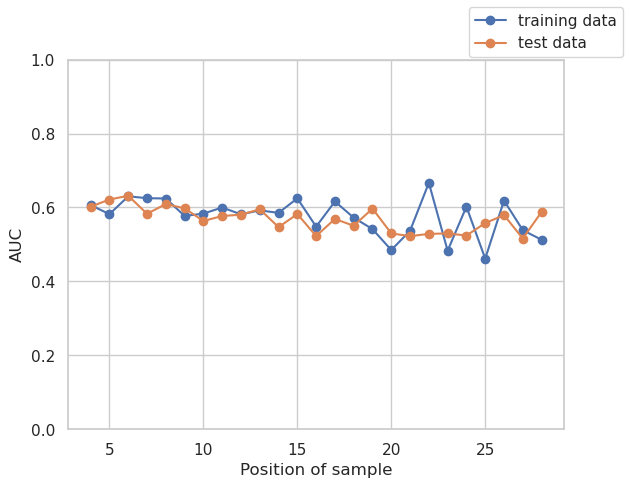

In [224]:
fig, ax = plot_roc_per_sample_position(AUC_TEST, AUC_TRAIN, POSITION_OF_SAMPLES)
